In [1]:
# import proplot as pplt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
# import proplot as pplt
import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model

import mdn
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'

SEED = 9887


In [2]:
df_chunk_0 = pd.read_parquet("data_chunk_0.parquet")
df_chunk_1 = pd.read_parquet("data_chunk_1.parquet")

df_all = pd.concat([df_chunk_0, df_chunk_1])

In [3]:
input_parameters = [
    'Mass', 
    'Radius',
    'FeMg',
    'SiMg',
]


output_parameters = [
    'WRF',
    'MRF',
    'CRF',
    'WMF',
    'CMF', 
    'CPS',
    'CTP',
    'k2'
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "model.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("Xscaler.save")
output_scaler = joblib.load("yscaler.save")

X = df_all[input_parameters]
y = df_all.loc[:, output_parameters]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
_, X_test_pre, _, y_test_pre = train_test_split(X_test, y_test, test_size=0.2, random_state=SEED)
scaled_Xtest = input_scaler.transform(X_test_pre)
scaled_ytest = output_scaler.transform(y_test_pre)

In [4]:
len(y_test_pre)

70560

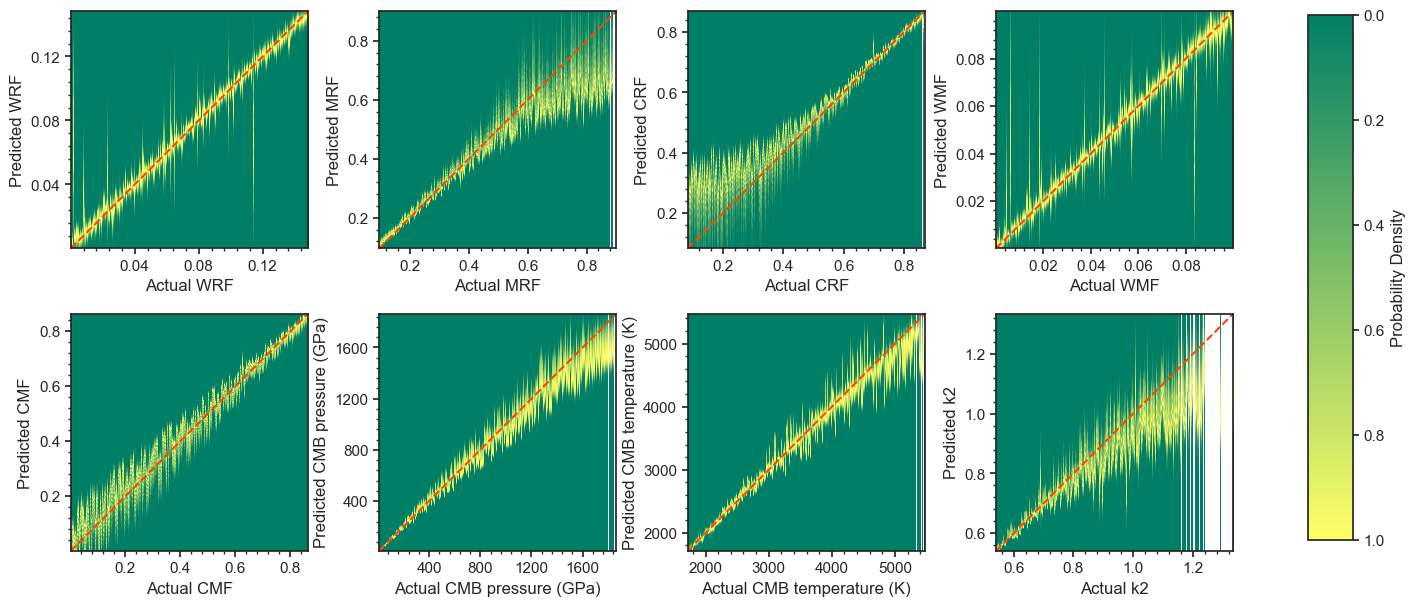

In [24]:
pred = model.predict(scaled_Xtest)
# pred contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

y_label = np.arange(0,1,0.001).reshape(-1,1)
cmap = plt.cm.summer
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

xlabels = [
    "Actual WRF","Actual MRF", "Actual CRF", 
    "Actual WMF","Actual CMF", "Actual CPS (GPa)", "Actual CTP (K)",
    "Actual k2", 
]
ylabels = [
    "Predicted WRF","Predicted MRF", "Predicted CRF", 
    "Predicted WMF","Predicted CMF", "Predicted CPS (GPa)", "Predicted CTP (K)",
    "Predicted k2", 
]

xlocators = [
    0.04, 0.2, 0.2, 0.02, 0.2, 400, 1000, 0.2
]
# xminorlocators = [
#     0.008, 0.04, 
# ]

custom_params = {"axes.spines.right": True, 
                 "axes.spines.top": True,
                 "xtick.major.size": 4,   # length of major x-axis ticks
                 "xtick.minor.size": 2,   # length of minor x-axis ticks
                 "ytick.minor.size": 2,   # length of minor y-axis ticks
                 "ytick.major.size": 4}   # length of major y-axis ticks
        

sns.set_theme(style="ticks", rc=custom_params)
f, axes = plt.subplots(2, 4, figsize=(15, 7.5), sharex=False, sharey=False)
for i, ax in enumerate(axes.flat):
    y_max = max(y_test_pre[output_parameters[i]])
    y_min = min(y_test_pre[output_parameters[i]])
    for c in range(len(y_test_pre)):
        for m in range(OUTPUT_DIMS):
            locals()['mus'+str(m)] = []
            locals()['sigs'+str(m)] = []
            for n in range(N_MIXES):
                locals()['mus'+str(m)].append(mus[c][n*OUTPUT_DIMS + m])
                locals()['sigs'+str(m)].append(sigs[c][n*OUTPUT_DIMS + m])
        mus_ = np.array(locals()['mus'+str(i)])
        sigs_ = np.array(locals()['sigs'+str(i)])
        factors = 1 / math.sqrt(2*math.pi) / sigs_
        exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
        GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # Sum over multiple Gaussian distributions
        MM = MinMaxScaler()
        GMM_PDF_scaled = MM.fit_transform(GMM_PDF.reshape(-1, 1))
        tx, ty = [y_test_pre.values[c,i],y_min]
        ax.imshow(
            GMM_PDF_scaled.reshape(-1, 1),
            cmap=cmap, 
            norm=norm, 
            origin='lower', 
            extent=(tx, tx + 0.00001, ty, y_max)
        )
    ax.plot([y_min, y_max], [y_min, y_max], c='orangered', ls='--')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(xlocators[i]))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(xlocators[i]))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.set_xlabel(xlabels[i], fontsize=12)
    ax.set_ylabel(ylabels[i], fontsize=12)
    ax.set_xlim([y_min, y_max])
    ax.set_ylim([y_min, y_max])
    
    
import matplotlib as mpl

f.subplots_adjust(wspace=0.3, hspace=0.1)
for ax in axes.flat:
    ax.set_aspect('equal')

# Add colorbar
colorbar_ax = f.add_axes([0.95, 0.15, 0.03, 0.7])
colorbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=colorbar_ax)
# Invert colorbar 
colorbar.ax.invert_yaxis()  
colorbar.set_label('Probability Density', fontsize=12)

# Adjust layout with colorbar
# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0, rect=[0, 0, 0.9, 1])    
#     if i == 1:
#         break
# plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0, rect=[0,0,0.9,1])
plt.savefig('MDN_performance.pdf')